# CLINT WP5: Debug for the maps of HW in ERA5 with the new drivers df
## After changing the format of the drivers df, the maps are not produced anymore
### 2023/10/27 - ongoing


In [62]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import importlib
import seaborn as sns
#from mpl_toolkits import Basemap
import CLINT001_functions as clint
import matplotlib.ticker as mticker
importlib.reload(clint)

<module 'CLINT001_functions' from '/users_home/csp/as18623/CLINT_WP5/CLINT001_functions.py'>

In [2]:
## DIRECTORIES
machine = 'juno'
kind = 'ERA5' #ERA5 or hist
experiment = 5

if machine == 'laptop':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    metadatadir = '~/Library/Mobile\ Documents/com~apple~CloudDocs/CLINT/metadata/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/squintu/Documents/CMCC-GoogleDrive/plots_for_reports/'
    
if machine == 'workstation':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    metadatadir = '~/Library/Mobile\ Documents/com~apple~CloudDocs/CLINT/metadata/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/antonellosquintu/Documents/CMCC-GoogleDrive/plots_for_reports/'

if machine == 'juno':
    modeldir = f'/work/csp/as18623/CLINT_{kind}/'
    obsdir = '/data/csp/as18623/CLINT_obs/'
    workmetadir = '/work/csp/as18623/CLINT_metadata/'
    metadatadir = '/data/csp/as18623/CLINT_metadata/'
    maskdir = '/data/csp/as18623/CLINT_metadata/Masks/Test3_Clusters/'
    plotdir = '/work/csp/as18623/CLINT_WP5/maps_and_plots/'

In [3]:
modelspecs = pd.DataFrame({'kind':['ERA5','hist'],
                           'modelnames':['era5','CMCC-CM2-SR5'],#name of models
                           'members_list':[np.nan,np.array(range(3,12))]})#list of member numbers)

modelspecs = pd.DataFrame({'kind':['ERA5','hist'],
                           'modelnames':['era5','CMCC-CM2-SR5'],#name of models
                           'members_list':[np.nan,[3]]})#list of member numbers)


In [4]:
modelspecs

,kind,modelnames,members_list
0,ERA5,era5,NaN
1,hist,CMCC-CM2-SR5,[3]


In [5]:
varspecs = pd.read_csv(f'{workmetadir}variables_specifications.csv')

In [6]:
## Open land-sea mask and round to integer
## The mask has values between 0 and 1 according to the proportion of the grid-point
##  which is covered by land
## Any gridpoint with more than 0.5 is rounded to 1 and considered land

lsm = xr.open_dataset(f'{obsdir}/era5_lsm.nc').round()

In [7]:
### Read series of tmax and HWMI related to Lake Como
lchw = pd.read_csv('LakeComo_tmax_HW.csv',index_col='date')

In [8]:
### Identify 2019 heat wave

row_maxHWMI = lchw.loc[lchw['Valle_HWintensity'].idxmax()]
date2019_dt = dt.strptime(row_maxHWMI.name,"%Y-%m-%d")
date2019_ts = pd.to_datetime(date2019_dt)

In [9]:
### Identify dates
date_aux_dt = dt.strptime(lchw.loc[lchw.year==1983]['Valle_HWintensity'].idxmax(),"%Y-%m-%d")
date_aux_ts = pd.to_datetime(date_aux_dt)

In [11]:
variables = ['tmax']

In [10]:
## indicate the date of the events and the variables to be included

dates_ts = (pd.to_datetime("2022-07-22"), 
            pd.to_datetime("2019-06-27"), 
            pd.to_datetime("2003-08-11"), 
            pd.to_datetime("1983-07-21"))

## don't run too many dates at once otherwise the notebook won't open next time

dates_ts =[pd.to_datetime("2019-06-27")]
dates_ts1 = dates_ts


if kind == 'ERA5':
    houroffset = 0 #daily files of era5 are labeled with 00 UTC
else:
    houroffset = 12 #daily files of CMIP6 are labeled with 12 UTC

dates_ts = [d + pd.DateOffset(hours = houroffset) for d in dates_ts]

date_ts = dates_ts[0]
## daily series of ERA5

#variables = ['tmax','mslp','sm']

In [11]:
dates_ts

[Timestamp('2019-06-27 00:00:00')]

In [32]:
importlib.reload(clint)
drivers = pd.read_csv(f'{workmetadir}drivers{experiment}_Test.csv')

## lines from clint.loop_map_grids

In [13]:
kind = 'ERA5'
date_ts = dates_ts [0]
modelspecs1 = modelspecs[modelspecs.kind == kind]

In [19]:
y = date_ts.year
#print(y)
kind = modelspecs1.iloc[0]['kind']

if kind == 'ERA5':
    datasetnames = ['era5']
    kind_var = 'era5_var'
else:
    #[print(modelrow) for i, modelrow in modelspecs.iterrows()]
    datasetnames = sum([[f'{modelrow["modelnames"]}-{kind}-r{mmb}' for mmb in modelrow["members_list"]] for i, modelrow in modelspecs1.iterrows()],[])
    kind_var = 'cmip6_var'
    


In [20]:
var = 'tmax'
datasetname = datasetnames[0]

In [37]:
drivers_sub = drivers.loc[drivers['var'] == var]
nc_var = drivers.loc[drivers['var'] == var].iloc[0][kind_var]

In [22]:
nc_var

'mx2t'

In [23]:
anom_xr = xr.open_dataset(f'{modeldir}/{datasetname}_{var}_dailyanom_{y}_cropped.nc')
anom_xr = anom_xr.convert_calendar('gregorian')
if var == 'mslp':
    anom_xr[nc_var] = anom_xr[nc_var]/100


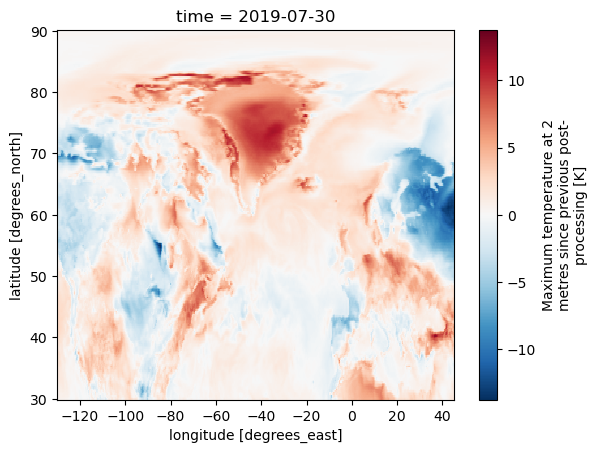

In [24]:
anom_xr.isel(time=210)['mx2t'].plot()

In [38]:
drivers_row = drivers_sub.iloc[0]

In [78]:
drivers_row

var                                                             tmax
era5_var                                                        mx2t
cmip6_var                                                     tasmax
exp                                                                5
exp_size                                                         low
domain                                                        Europe
cl_nr                                                              1
cl_name                                          cl5low_Europe1_tmax
cl_code                                                          NaN
cl_info                                                          NaN
clmask_path        /data/csp/as18623/CLINT_metadata/Masks/Test5lo...
clmask_file        /data/csp/as18623/CLINT_metadata/Masks/Test5lo...
minlag                                                            57
maxlag                                                            67
cl_centroid_lon                   

In [80]:

mask_df = pd.read_csv(f"{drivers_row['clmask_file']}",index_col=[0])
cl_nr = drivers_row['cl_nr']
submask = mask_df[mask_df.cluster == cl_nr-1]
maskedanom = clint.mask_xr_w_df(var, anom_xr, submask, lsm, kind)


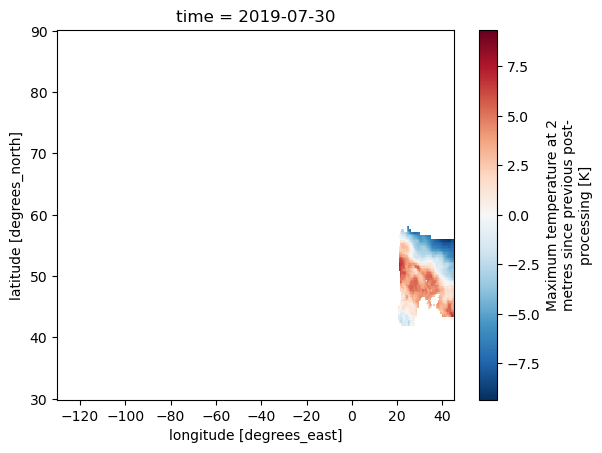

In [81]:
maskedanom.isel(time=210)['mx2t'].plot()

In [82]:
xrdf = maskedanom

<!-- ## lines from clint.mask_xr_w_df
<!-- Trying to understand why maskedanom has no datetime object -->

<!-- ## lines from clint.apply_land_sea_mask -->
<!-- Trying to understand why subxrdf has no datetime object -->

## lines from clint.multimaps_lag 

In [83]:
targetdate_ts = date_ts

In [84]:
targetdate_ts

Timestamp('2019-06-27 00:00:00')

In [85]:
drivers

,var,era5_var,cmip6_var,exp,exp_size,domain,cl_nr,cl_name,cl_code,cl_info,...,cl_ext_S,cl_ext_N,vmin,vmax,text_plot_lon,text_plot_lat,fig_width,ax_width,ax_height,empty
0,tmax,mx2t,tasmax,5,low,Europe,1,cl5low_Europe1_tmax,NaN,NaN,...,42.0,58.0,-10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
1,tmax,mx2t,tasmax,5,low,Europe,2,cl5low_Europe2_tmax,NaN,NaN,...,39.0,63.5,-10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2,mslp,msl,pls,5,low,Europe,3,cl5low_Europe3_mslp,NaN,NaN,...,57.0,71.0,-20.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
3,mslp,msl,pls,5,low,World,2,cl5low_World2_mslp,NaN,NaN,...,-76.0,-46.5,-20.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
4,sm,swvl1,mrsos,5,low,Europe,1,cl5low_Europe1_sm,NaN,NaN,...,42.0,62.0,-0.2,0.2,NaN,NaN,NaN,NaN,NaN,NaN
5,sm,swvl1,mrsos,5,low,Europe,2,cl5low_Europe2_sm,NaN,NaN,...,29.0,71.0,-0.2,0.2,NaN,NaN,NaN,NaN,NaN,NaN
6,sm,swvl1,mrsos,5,low,Europe,5,cl5low_Europe5_sm,NaN,NaN,...,34.0,51.0,-0.2,0.2,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
vmin,vmax='drivers','drivers'

In [87]:
var = drivers_row['var']
cl_name = drivers_row['cl_name']


In [88]:

minlag = int(drivers_row['minlag'])
maxlag = int(drivers_row['maxlag'])

fig_width = drivers_row['fig_width']
if np.isnan(fig_width):
    fig_width = 48

## VALUES THAT DEPEND ON THE VARIABLE

if vmin == 'drivers':
    vmin = drivers_row['vmin']
if vmax == 'drivers':
    vmax = drivers_row['vmax']
    var = drivers_row['var']

if kind == 'ERA5':
    nc_var = drivers_row.era5_var
elif kind == 'hist':
    nc_var = drivers_row.cmip6_var

if var == 'tmax':
    palette = plt.cm.RdBu_r
if var == 'mslp':
    palette = plt.cm.PRGn_r
if var == 'sm':
    palette = plt.cm.BrBG


In [100]:
## DEFINE PROJECTION AND MAP EXTENT

my_projn = ccrs.Orthographic(central_longitude=drivers_row['cl_ortho_lon'],
                             central_latitude=drivers_row['cl_ortho_lat'])
lonlatproj = ccrs.PlateCarree()
# These chunk, first takes the limits of the box then calculates the coordinated in the projection
# In the last line, the extreme coordinates in the new reference are identified
# These extremes are give to set_extent()
SW_lon, SW_lat = my_projn.transform_point(drivers_row['cl_ext_W']-1, 
                                        drivers_row['cl_ext_S']-1, 
                                        lonlatproj)  #(0.0, -3189068.5)
NE_lon, NE_lat = my_projn.transform_point(drivers_row['cl_ext_E']+1, 
                                        drivers_row['cl_ext_N']+1, 
                                        lonlatproj) #(3189068.5, 0)
NW_lon, NW_lat = my_projn.transform_point(drivers_row['cl_ext_W']-1, 
                                        drivers_row['cl_ext_N']+1, 
                                        lonlatproj)  #(0.0, -3189068.5)
SE_lon, SE_lat = my_projn.transform_point(drivers_row['cl_ext_E']+1, 
                                        drivers_row['cl_ext_S']-1, 
                                        lonlatproj) #(3189068.5, 0)
SC_lon, SC_lat = my_projn.transform_point(drivers_row['cl_ortho_lon'], 
                                        drivers_row['cl_ext_S']-1, 
                                        lonlatproj) #(3189068.5, 0)
NC_lon, NC_lat = my_projn.transform_point(drivers_row['cl_ortho_lon'], 
                                        drivers_row['cl_ext_N']+!=1, 
                                        lonlatproj) #(3189068.5, 0)

xmin,xmax,ymin,ymax = min(SW_lon,NW_lon), max(NE_lon,SE_lon), min(SW_lat,SE_lat,SC_lat), max(NE_lat,NW_lat, NC_lat)

## DEFINE SIZE OF SUBPLOTS

numfigs = len(range(minlag,maxlag+1)) ## number of figures depends on how many days
numfigs_h = np.floor((12000000/(xmax-xmin)+3)/2) ## number of figures per row depends on the size of the cluster
numfigs_v = np.ceil(numfigs/numfigs_h) ## number of rows is calculated by consequence

map_ratio = (xmax-xmin)/(ymax-ymin) ## width divided by height

ax_width = drivers_row['ax_width']
if np.isnan(ax_width):        
    ax_width = (fig_width-1)/numfigs_h    
ax_height = drivers_row['ax_height']
if np.isnan(ax_height):
    ax_height = ax_width/map_ratio
 

In [101]:
## DEFINE WHERE TO WRITE THE LAG    

text_plot_lon = drivers_row['text_plot_lon']
if np.isnan(text_plot_lon):
    text_plot_lon = drivers_row['cl_ext_E']-2

text_plot_lat = drivers_row['text_plot_lat']
if np.isnan(text_plot_lat):
    text_plot_lat = drivers_row['cl_ext_N']-2

## IDENTIFY THE DATES

targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d %H')

y = targetdate_ts.year
m = str(targetdate_ts.month).zfill(2)
d = str(targetdate_ts.day).zfill(2)

# Determine extremes of the date range considered, in the netcdf every day has 12:00 as hour
mintime_ts = targetdate_ts - pd.DateOffset(days = maxlag) + pd.DateOffset(hours = 12)
maxtime_ts = targetdate_ts - pd.DateOffset(days = minlag) + pd.DateOffset(hours = 12)

mintime_str = dt.strftime(mintime_ts,'%Y-%m-%d')
maxtime_str = dt.strftime(mintime_ts,'%Y-%m-%d')

targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d')


-1005697.6002534389

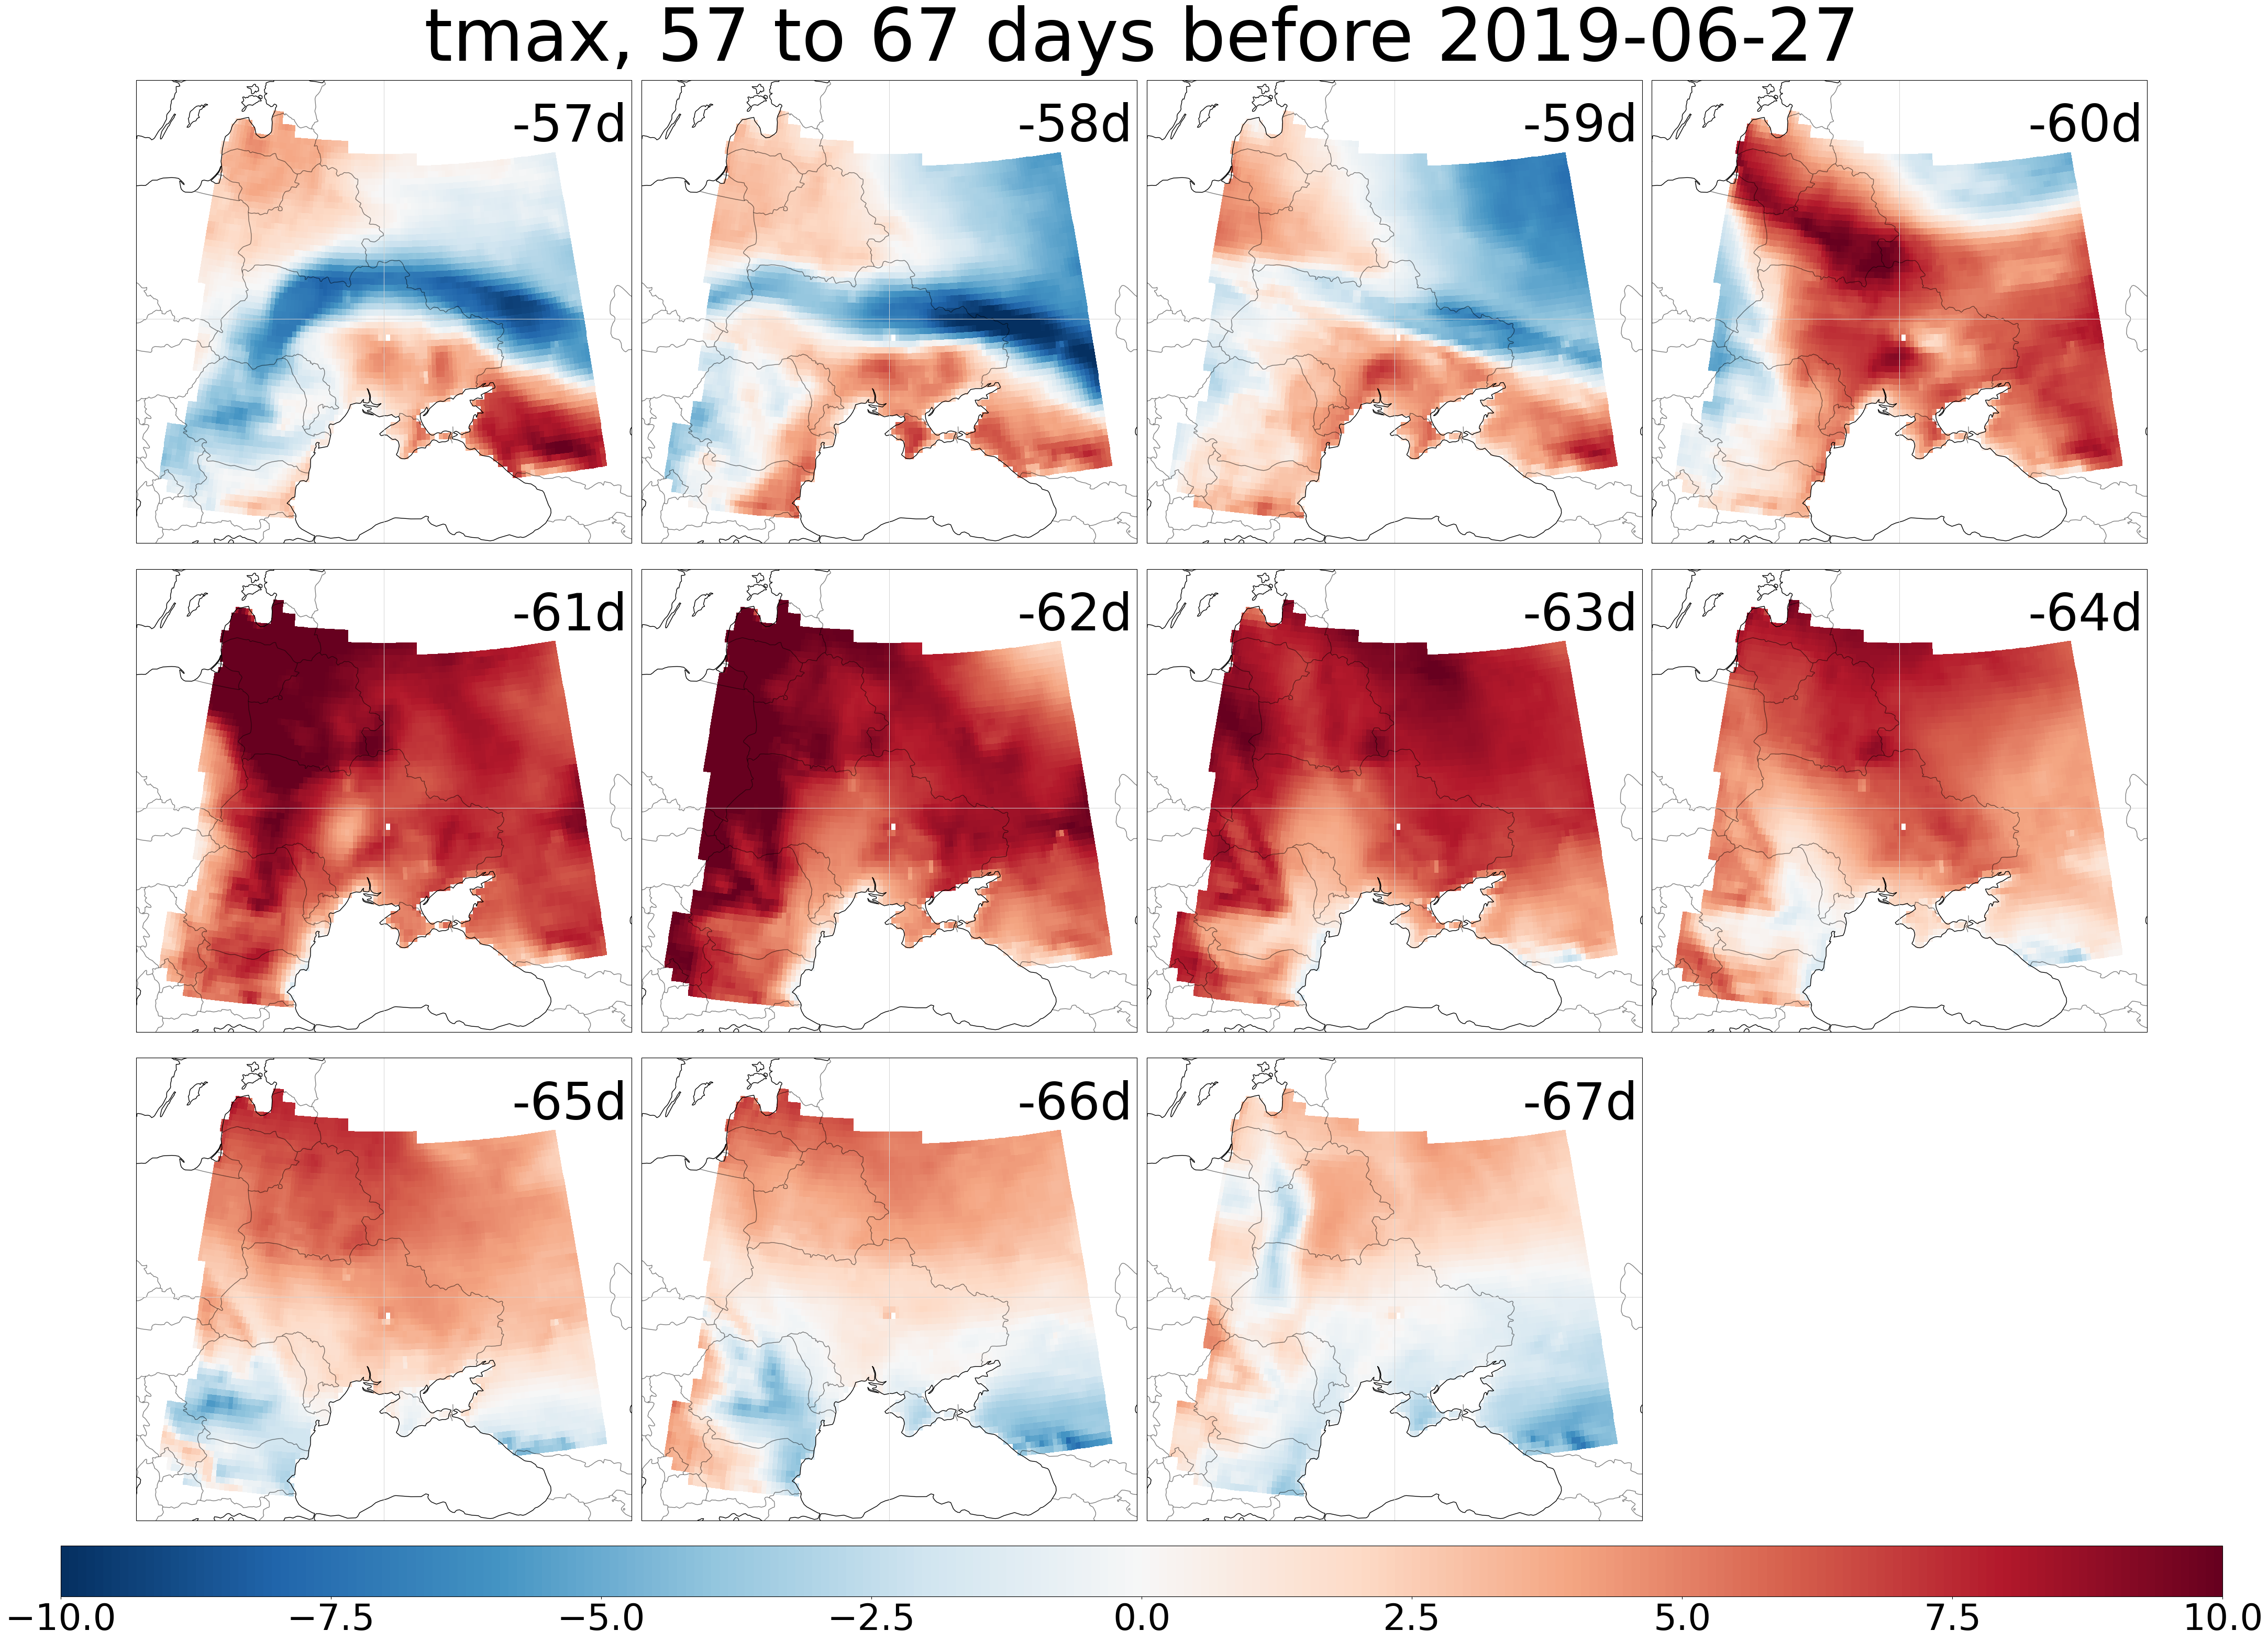

In [107]:
fig, axs = plt.subplots(int(numfigs_v), int(numfigs_h),
                        subplot_kw={'projection': lonlatproj},
                        figsize=(fig_width,int(numfigs_v*ax_height)),
                        sharey=True,sharex=True)#,
                        #layout="constrained")
fig.suptitle(f'{var}, {minlag} to {maxlag} days before {targetdate_str}', fontsize = 100)
axs = axs.flatten()        

for f,lag in enumerate(range(minlag,maxlag+1)):



    plotdate_ts = targetdate_ts - pd.DateOffset(days = lag)# + pd.DateOffset(hours = 12)
    #print(plotdate_ts)
    sub1d = xrdf.sel(time=plotdate_ts)
    axs[f].remove()
    geo_axes = plt.subplot(int(numfigs_v), int(numfigs_h), f+1,
                           projection=my_projn)

    #print(sub1d.variables)

    cs=sub1d[nc_var].plot(ax=geo_axes,transform=ccrs.PlateCarree(),cmap=palette, 
                       vmin = vmin, vmax = vmax,add_colorbar=False)





    geo_axes.scatter(x=drivers_row['cl_centroid_lon'], y=drivers_row['cl_centroid_lat'],
                marker='X',color='black',s=900,transform=ccrs.PlateCarree(),alpha=1)
    geo_axes.coastlines()
    geo_axes.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    #geo_axes.text(x=text_plot_lon, y=text_plot_lat, 
    #              s=f'-{lag}d', transform=ccrs.PlateCarree(), fontsize=70)
    geo_axes.text(x=0.875, y=0.9, horizontalalignment='center', verticalalignment='center',
                  s=f'-{lag}d', transform=geo_axes.transAxes, fontsize=70)
    geo_axes.set_extent([xmin,xmax,ymin,ymax], crs=my_projn) # data/projection coordinates  
    gl = geo_axes.gridlines(my_projn,linewidth=0.5, color='lightgray', alpha=0.5)
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    plt.title(None)
for f in range(numfigs,int(numfigs_h*numfigs_v)):
    #print(f)
    fig.delaxes(axs[int(f)])  

fig.subplots_adjust(bottom=0.04+1/(numfigs_v*ax_height), top=0.94, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

cbar_ax = fig.add_axes([0.07, 0.03, 0.86,1/(numfigs_v*ax_height)])

cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=50)
plt.savefig(f"{plotdir}CLINT040_maps_{y}{m}{d}case_{var}_{cl_name}.png", facecolor='w')

In [64]:
drivers_row

var                                                             tmax
era5_var                                                        mx2t
cmip6_var                                                     tasmax
exp                                                                5
exp_size                                                         low
domain                                                        Europe
cl_nr                                                              1
cl_name                                          cl5low_Europe1_tmax
cl_code                                                          NaN
cl_info                                                          NaN
clmask_path        /data/csp/as18623/CLINT_metadata/Masks/Test5lo...
clmask_file        /data/csp/as18623/CLINT_metadata/Masks/Test5lo...
minlag                                                            57
maxlag                                                            67
cl_centroid_lon                   